This notebook is part of the PyImageJ [Tutorial Series](./notebooks.rst), and assumes familiarity with the ImageJ API. Dedicated tutorials for ImageJ can be found [here](https://imagej.net/tutorials/).S

# 11 Working with the original ImageJ

So far, we have limited ourselves to the world of ImageJ2. But PyImageJ also includes support for the original ImageJ.

You can tell whether a Java class is part of ImageJ or ImageJ2 by its package prefix:

|   | Project | Prefix | Example class |
|---|---------|--------|---------------|
| ![](https://scijava.org/icons/imagej-icon-64.png) | [ImageJ](https://imagej.net/software/imagej) | `ij` | `ij.ImagePlus` |
| ![](https://scijava.org/icons/imagej2-icon-64.png) | [ImageJ2](https://imagej.net/software/imagej2) | `net.imagej` | `net.imagej.Dataset` |

The [original ImageJ API](https://javadoc.scijava.org/ImageJ1/) is simpler than [that of ImageJ2](https://javadoc.scijava.org/ImageJ2/) in many ways. However, the design of ImageJ imposes some important restrictions.

## 11.1 Original ImageJ in headless mode
The original ImageJ is a fundamentally GUI-driven application. Some of its features do not work in [headless mode](https://imagej.net/learn/headless), which (as explained in [Using PyImageJ without a screen](Headless.md)) is PyImageJ's default mode. In particular, ***you cannot use `RoiManager` or `WindowManager` headless***. PyImageJ makes a best effort to warn you if you attempt to perform such unsupported operations. For further details, see the section ["The original ImageJ API is limited in headless mode"](https://github.com/imagej/pyimagej/blob/1.2.0/doc/Troubleshooting.md#the-original-imagej-api-is-limited-in-headless-mode) of the PyImageJ Troubleshooting guide.

In [1]:
import imagej

# initialize ImageJ
ij = imagej.init(mode='headless')
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.9.0/1.53t


Note that `mode='headless'` isn't necessary to specify here. PyImageJ's default mode is headless, thus `ij = imagej.init()` is equivalent to specifying the `headless` mode.

Accessing ImageJ resources that do not function headless will produce a warning about limited functionality.

In [2]:
ij.WindowManager.getCurrentImage()

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the WindowManager class will not be fully functional.


## 11.2 One ImageJ-enabled gateway at a time

ImageJ was not designed to run multiple simultaneous instances in the same JVM, whereas ImageJ2 supports multiple gateways at once.

In [3]:
def legacy_status(gateway):
    print(f" legacy service: {gateway.legacy}")
    print(f"  legacy active? {gateway.legacy and gateway.legacy.isActive()}")
    print(f"ImageJ2 version: {gateway.getVersion()}")

another_ij = imagej.init()
print("[ij - the original gateway]")
legacy_status(ij)
print("\n[another_ij - a second gateway we constructed just now]")
legacy_status(another_ij)

Operating in headless mode - the original ImageJ will have limited functionality.


[ij - the original gateway]
 legacy service: net.imagej.legacy.LegacyService [priority = 1.0]
  legacy active? True
ImageJ2 version: 2.9.0/1.53t

[another_ij - a second gateway we constructed just now]
 legacy service: net.imagej.legacy.LegacyService [priority = 1.0]
  legacy active? False
ImageJ2 version: 2.9.0/Inactive


## 11.3 Converting images to `ImagePlus`


The `ij.py.to_imageplus(image)` function converts an image to an `ij.ImagePlus`.

dataset type: <java class 'net.imagej.DefaultDataset'>
imp type: <java class 'ij.ImagePlus'>


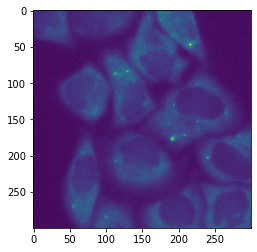

In [4]:
# load data and conver to ImagePlus
dataset = ij.io().open('sample-data/test_still.tif')
imp = ij.py.to_imageplus(dataset)

# print types
print(f"dataset type: {type(dataset)}")
print(f"imp type: {type(imp)}")

# show imp
ij.py.show(imp)

In interactive mode, you can display an `ImagePlus` using `ij.ui().show(imp)` as described in [06 Working with Images](06-Working-with-Images.ipynb), or by calling `imp.show()`.

***But beware:*** if you then close the image window, ImageJ will *dispose* the `ImagePlus`, leaving it in an unusable state.

Note that PyImageJ does not implement `dtype`, slicing, or element access for `ImagePlus` objects yet. See [imagej/pyimagej#194](https://github.com/imagej/pyimagej/issues/194) for details.

## 11.4 Converting `ImagePlus` to other image formats

If you have an `ImagePlus`, but would like something else:

* `ij.py.to_dataset(imp)` will convert it to a `net.imagej.Dataset`.
* `ij.py.from_java(imp)` will convert it to an xarray.

In [5]:
imp2ds = ij.py.to_dataset(imp)
xr = ij.py.from_java(imp)

Now we need to be careful here as Python and ImageJ/ImgLib2 have different dimension order preferences. Let's print out the dimensions and shape of `imp2ds` and `xr`.

In [6]:
print(f"imp2ds dims: {imp2ds.dims}\nimp2ds shape: {imp2ds.shape}")
print(f"xr dims: {xr.dims}\nxr shape: {xr.shape}")

imp2ds dims: ('X', 'Y')
imp2ds shape: (300, 300)
xr dims: ('row', 'col')
xr shape: (300, 300)


Here we can see that `imp2ds` and `xr` actually have inverted dimension orders to each other (note that `row` is the y-axis and `col` is the x-axis). For more on dimension order in PyImageJ infomration see [06 Working with Images](06-Working-with-Images.ipynb).

## 11.5 Keeping image data in sync with `ij.py.sync_image(imp)`

PyImageJ is built on `imglyb` which allows direct wrapping of NumPy array data into special `RandomAccessibleInterval` structures, avoiding the duplication of data. However, when working with an `ImagePlus` in PyImageJ it is important to understand that the original ImageJ has logic that can cause unexpected behavior when modifying the pixel values of the image (whether by direct modification or through a plugin). Let's look at an example of this in action.

We'll start by loading a new image and converting it to an `ImagePlus`:

skin: [219, 217, 211, 219, 217, 211, 220, 215, 211]
skimp: [219, 217, 211, 219, 217, 211, 220, 215, 211]


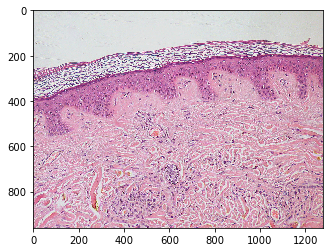

In [7]:
import skimage, xarray

skin = xarray.DataArray(skimage.data.skin(), name='skin', dims=('row', 'col', 'ch'))
skimp = ij.py.to_imageplus(skin)

def print_3x3_corner():
    print(f"skin: {[int(skin[y,x,0]) for x in range(3) for y in range(3)]}")
    print(f"skimp: {[skimp.getPixel(x,y)[0] for x in range(3) for y in range(3)]}")
print_3x3_corner()

ij.py.show(skin)

To modify the values of our image, we can use the `ImageProcessor` from our `ImagePlus` by calling the [`getProcessor()`](https://imagej.nih.gov/ij/developer/api/ij/ij/ImagePlus.html#getProcessor()) method. `ImageProcessor` has a number of methods available for modifying pixel values; in this case let's use the simple [`set(double)`](https://imagej.nih.gov/ij/developer/api/ij/ij/process/ImageProcessor.html#set(double)) method to set all pixels to `17` (a number unlikely to come up otherwise by chance).


In [8]:
skimp.getProcessor().set(17)
assert skimp.getPixel(0,0)[0] == 17

Now let's compare the pixel values of the `ImagePlus` and the original.

skin: [219, 217, 211, 219, 217, 211, 220, 215, 211]
skimp: [17, 17, 17, 17, 17, 17, 17, 17, 17]


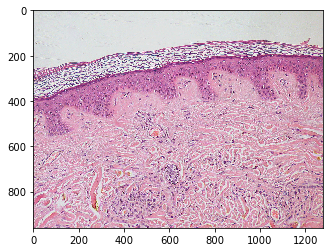

In [9]:
print_3x3_corner()
ij.py.show(skin)

Is this what you expected? As you can see, the `ImagePlus` is aware of the updated pixel values, but that change hasn't propagated through to the backing NumPy array. For this reason, we created the `ij.py.sync_image` helper method, to sync `ImagePlus` changes back to ImageJ2 and Python.


In [10]:
# sync the ImagePlus to update the backing NumPy array
ij.py.sync_image(skimp)

Now that `skimp` has been synced, let's view the image again.

skin: [17, 17, 17, 17, 17, 17, 17, 17, 17]
skimp: [17, 17, 17, 17, 17, 17, 17, 17, 17]


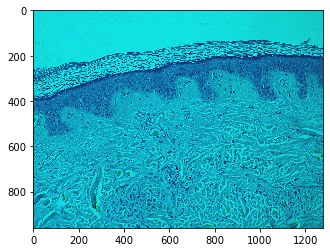

In [11]:
print_3x3_corner()
ij.py.show(skin)

Red channel is effectively gone because it's 17s all the way down now.

This step is necessary because the original ImageJ makes a copy of image data from ImgLib2 (and therefore Python) on a plane-by-plane basis, and modifications happen directly on that copied data, rather than on the original data.

## 11.6 Invoking ImageJ Plugins

The `ij.py.run_plugin` function lets you run ImageJ plugins from Python.

Running ImageJ plugins from script languages is typically done via `ij.IJ.run(imp, plugin, args)`, where `imp` is the `ImagePlus` to make active during plugin execution, `plugin` is the ***label in the menus*** (as recorded by the [Macro Recorder](https://imagej.net/scripting/macro#the-recorder)), and `args` is a ***single space-separated string of arguments***, e.g. `"path=[/data/image.tif] gamma=2 overwrite"`.

To make this more Pythonic, PyImageJ provides a helper function `ij.py.run_plugin(plugin, args={}, imp=None)` where `args` is a `dict` of variables, and `imp` is an optional `ImagePlus`; if no `imp` is given, the `ij.IJ.run(plugin, args)` method without `ImagePlus` argument is used instead. For example: `ij.py.run_plugin(plugin, {'path': '/data/image.tif', 'gamma': 2, 'overwrite': True})`.

Let's try it. First we create a new `ImagePlus`:

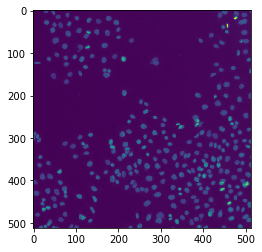

In [12]:
import skimage
mitepy = skimage.data.human_mitosis()
miteimp = ij.py.to_imageplus(mitepy)
ij.py.show(miteimp)

Now let's blur the image using the "Gaussian Blur..." plugin, which modifies the image in-place.

Operating in headless mode - the IJ class will not be fully functional.


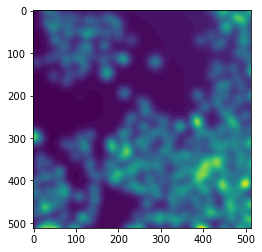

In [13]:
args = {"sigma": 10}
ij.py.run_plugin("Gaussian Blur...", args, imp=miteimp)
ij.py.sync_image(miteimp) # see section 11.5 for details
ij.py.show(miteimp)

## 11.7 Running ImageJ macros

The `ij.py.run_macro` function lets you run [ImageJ macros](https://imagej.net/scripting/macro) from Python.

Before you get too excited, there are some things you should know:
* The macro language does not support the complete ImageJ API, only a set of [built-in functions](https://imagej.nih.gov/ij/developer/macro/functions.html), although there are [ways to work around this](https://imagej.net/scripting/macro#overcoming-limitations).
* Macros are executed by a custom interpreter that is buggier and less well tested than other script languages (Groovy, JRuby, Jython, etc.).
* Macros are not intended to run concurrently, meaning you should only run one macro at a time.
* Macros only support three data types: numbers, strings, and simple arrays. Images are passed via numerical IDs.
* Macros rely on the ***active image***—i.e., the image window currently displayed in the foreground—which is tricky to get right while in headless mode.

<table><tr><td>

💡 See the ["Scripting with ImageJ" living workshop](https://imagej.net/events/presentations#living-workshops) for a primer on ImageJ macro programming.

</td></tr></table>

All of that said, macros are popular because they are simpler and easier to learn than other script languages. Let's look at using a macro that clears an image's background and center crops it.

In [14]:
background_clear_and_crop = """
setBatchMode(true);

// Compute image background.
original = getImageID();
run("Duplicate...", " ");
run("Median...", "radius=6");
setAutoThreshold("Li dark");
run("Create Selection");

// Clear background of the original image.
selectImage(original);
run("Restore Selection");
setBackgroundColor(0, 0, 0);
run("Clear Outside");

// Crop to center portion of the image.
x = getWidth() / 4
y = getHeight() / 4
makeRectangle(x, y, x*2, y*2);
run("Crop");
rename(getTitle() + "-cropped")
"""

<table><tr><td>

💡 A great tool for building up macros is the [Macro Recorder](https://imagej.net/scripting/macro#the-recorder)(see [08 Discover and run ImageJ commands](08-Discover-and-run-ImageJ-commands.ipynb)). It can also generate SciJava script code by changing the recorded language to JavaScript. Another powerful tool is the [SciJava Script Editor](https://imagej.net/scripting/script-editor), which has an autocomplete feature useful for exploring available functions.

</td></tr></table>

To run this script all we have to do is call `ij.py.run_macro` with this `background_crop_and_clear` macro. But first we need to set the image to be processed as the ***active image***. To do that, you must convert the desired image into an `ImagePlus` and then call `show()` on it. You can do this as a succinct one-liner: `ij.py.to_imageplus(image).show()`. Even in headless mode, the `show()` call is a clue to ImageJ to register and activate this image.

***Warning:*** There is currently a bug where `show()` triggers a `java.awt.HeadlessException` if there is not already at least one registered `ImagePlus`. So we will now employ a hacky workaround to avoid this problem:

In [15]:
# HACK: Work around ImagePlus#show() failure if no ImagePlus objects are already registered.
if ij.WindowManager.getIDList() is None:
    ij.py.run_macro('newImage("dummy", "8-bit", 1, 1, 1);')

Now we are ready to use this macro on the skimage `coins` sample image.

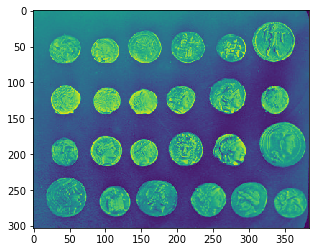

In [16]:
import skimage

coins = skimage.data.coins()
ij.py.show(coins)

Next we need to convert the image to `ImagePlus`, set the title and activate with the `show()` call.

In [17]:
coins_plus = ij.py.to_imageplus(coins)
coins_plus.setTitle("coins")
coins_plus.show()

In [18]:
assert ij.WindowManager.getImage("coins") is not None

Now that `coins` has been converted into an `ImagePlus` and activated as the active image, we can now use the macro.

In [19]:
ij.py.run_macro(background_clear_and_crop)

<java object 'org.scijava.script.ScriptModule'>

This example macro does not have any explicitly output script parameters. Thus, in order to obtain the result image we will need to ask for the image from the `WindowManager`. First let's see what windows are open now:

In [20]:
for imp_id in ij.WindowManager.getIDList():
    print(ij.WindowManager.getImage(imp_id))

img["dummy" (-6), 8-bit, 1x1x1x1x1]
img["coins-cropped" (-7), 8-bit, 192x152x1x1x1]
img["coins-1" (-8), 8-bit, 384x303x1x1x1]


Here we can see we have three images open. The first one, "dummy" is the dummy image we made with the headless hack. The other two images are the original coin image ("coins-1") and the cropped coins image ("coins-cropped"). Let's get the cropped image:

In [21]:
coins_cropped = ij.WindowManager.getImage("coins-cropped")
print(f"coins_cropped dims: {coins_cropped.dims}\ncoins_cropped shape: {coins_cropped.shape}")

coins_cropped dims: ('X', 'Y')
coins_cropped shape: (192, 152)


Now let's see it!

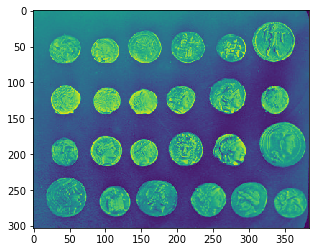

In [22]:
ij.py.show(coins_cropped)

Unfortunately, there is a bug here with the crop funcion when changing the `ImagePlus` dimensions where some synching fails to occur. One way around this, is to duplicate the image first.

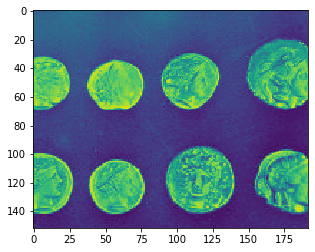

In [23]:
ij.py.show(coins_cropped.duplicate())